# The Eight Point Algorithm

In [1]:
from numpy import *
import matplotlib.pyplot as plt
%matplotlib ipympl

ModuleNotFoundError: No module named 'ipympl'

It may be useful to change the print options (for numpy) to make output more readable.

In [2]:
set_printoptions(precision=5,floatmode="maxprec",suppress=False)
# set_printoptions(precision=3,floatmode="fixed",suppress=True)

# Camera Configuration

Before we look at the second camera, we have to define the relative pose.  We shift the second camera 10 steps along the $x$ axis and rotate it 30° around the $y$ axis.  Note that the rotation is the standard form (Ma 2004:24) for multiplication with points as column vectors on the right.

In [3]:
phi = pi/6
Ry = array([[cos(phi),  0, -sin(phi)],
            [0,         1, 0],
            [sin(phi), 0, cos(phi)]] )
T = array([[10, 0, 0]]).T
print(Ry)
print(T)
def skewHat(T):
    x = T.flatten()
    return array( [ [ 0, -x[2], x[1] ], [x[2], 0, -x[0] ], [ - x[1], x[0], 0 ]  ])
That = skewHat(T)
print (That)

[[ 0.86603  0.      -0.5    ]
 [ 0.       1.       0.     ]
 [ 0.5      0.       0.86603]]
[[10]
 [ 0]
 [ 0]]
[[  0   0   0]
 [  0   0 -10]
 [  0  10   0]]


The true essential matrix can be calculated straight away.

In [4]:
Etrue = That @ Ry 
print(Etrue)

[[ 0.       0.       0.     ]
 [-5.       0.      -8.66025]
 [ 0.      10.       0.     ]]


# Point Configuration

We start by defining the eight points in 3D as the `p1` array.  Each row is a point.  These can be visualised for validation.

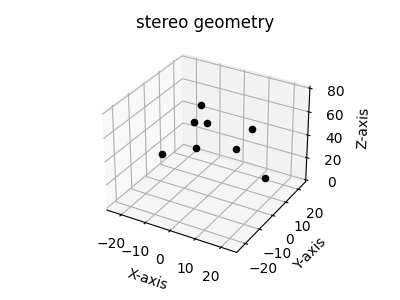

In [5]:
p1 = array([[-19, 0, 23],
            [21, 3, 24],
            [3, 15, 25],
            [-11, 9, 47],
            [12, 10, 53],
            [0, -8, 49],
            [-1, 1, 60],
            [-7, 7, 66]])

# define axis and figure
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111,projection='3d')

# set limits
ax.set(xlim=(-25, 25), ylim=(-25, 25), zlim=(0, 80))

# plot the world point
for i in range(len(p1)):
    ax.scatter(*p1[i], color="black")

ax.set_title("stereo geometry")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

plt.show()

Now, we need the projections in each camera frame.  The first camera is aligned with the world (3D) frame, so the projection is straight forward.  Let `p1_` be the image points in the first camera.

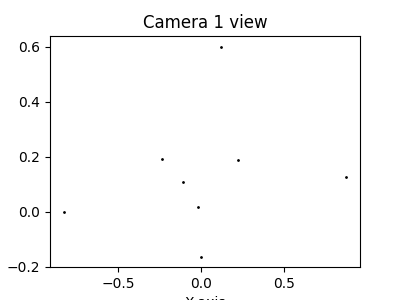

In [6]:
def project(p1):
   ps = [ p1[i] / p1[i][2] for i in range (len(p1)) ]
   return vstack(ps)
p1_ = project(p1)
fig = plt.figure(figsize=(4, 3))

ax = fig.add_subplot(111)
for i in range(len(p1_)):
    ax.scatter(*p1_[i], color="black")

ax.set_title("Camera 1 view")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")

plt.show()

Now we calculate the co-ordinates of the 3D points in the second camera frame, by applying the relative pose.  We should check at this point that all the points are visible, that is they have positive $z$-coordinate.

In [7]:
p2 = array(zeros((8, 3)), ndmin=2)
p2 = ( Ry @ p1.T + T ).T
print(p2)

[[-17.95448   0.       10.41858]
 [ 16.18653   3.       31.28461]
 [  0.09808  15.       23.15064]
 [-23.02628   9.       35.20319]
 [ -6.1077   10.       51.89935]
 [-14.5      -8.       42.43524]
 [-20.86603   1.       51.46152]
 [-29.06218   7.       53.65768]]


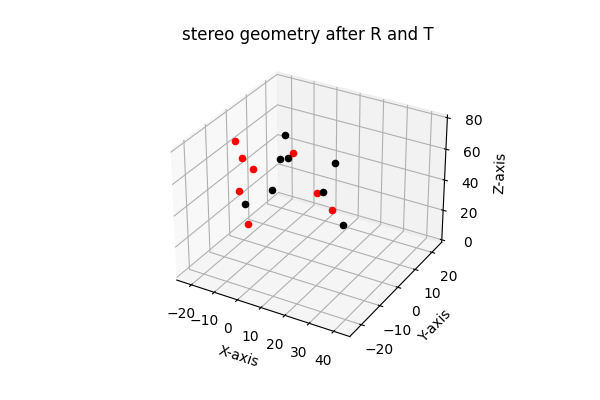

In [8]:
    
# define axis and figure
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111,projection='3d')

# set limits
#ax.set(xlim=(0, 45), ylim=(-15, 25), zlim=(0, 70))
ax.set(xlim=(-25, 45), ylim=(-25, 25), zlim=(0, 80))

# plot the world point
for i in range(len(p1)):
    ax.scatter(*p1[i], color="black")
    ax.scatter(*p2[i], color="red")

ax.set_title("stereo geometry after R and T")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

plt.show()

The image points are calculated as we did in the first camera frame.

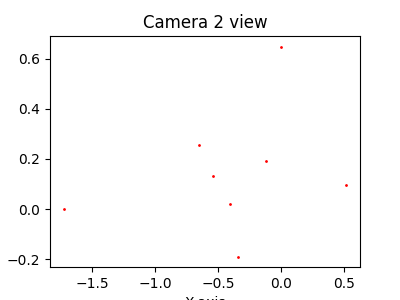

In [9]:
p2_ = project(p2)
fig = plt.figure(figsize=(4, 3))

ax = fig.add_subplot(111)
for i in range(len(p2_)):
    ax.scatter(*p2_[i], color="red")
    #ax.scatter(*p1_[i], color="black")

ax.set_title("Camera 2 view")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")

plt.show()

# Finding the Fundamental matrix

In [10]:
xs = [ kron(p1_[i], p2_[i]) for i in range (len(p1_)) ]
chi = vstack(xs)
xs0 = [ (p1_[i,newaxis].T @ p2_[i,newaxis]).flatten() for i in range (len(p1_)) ]
chi0 = vstack(xs0)
print( "Validation should be zero, if the calculations match:", (chi-chi0).max() )
print( "Shape of the chi matrix:", chi.shape)
print(chi)
X = chi.T @ chi
print(X)

Validation should be zero, if the calculations match: 0.0
Shape of the chi matrix: (8, 9)
[[ 1.42361e+00 -0.00000e+00 -8.26087e-01 -0.00000e+00  0.00000e+00
   0.00000e+00 -1.72331e+00  0.00000e+00  1.00000e+00]
 [ 4.52722e-01  8.39071e-02  8.75000e-01  6.46745e-02  1.19867e-02
   1.25000e-01  5.17396e-01  9.58938e-02  1.00000e+00]
 [ 5.08372e-04  7.77516e-02  1.20000e-01  2.54186e-03  3.88758e-01
   6.00000e-01  4.23644e-03  6.47930e-01  1.00000e+00]
 [ 1.53086e-01 -5.98350e-02 -2.34043e-01 -1.25252e-01  4.89559e-02
   1.91489e-01 -6.54096e-01  2.55659e-01  1.00000e+00]
 [-2.66453e-02  4.36258e-02  2.26415e-01 -2.22044e-02  3.63548e-02
   1.88679e-01 -1.17683e-01  1.92681e-01  1.00000e+00]
 [-0.00000e+00 -0.00000e+00  0.00000e+00  5.57873e-02  3.07792e-02
  -1.63265e-01 -3.41697e-01 -1.88523e-01  1.00000e+00]
 [ 6.75781e-03 -3.23867e-04 -1.66667e-02 -6.75781e-03  3.23867e-04
   1.66667e-02 -4.05468e-01  1.94320e-02  1.00000e+00]
 [ 5.74448e-02 -1.38363e-02 -1.06061e-01 -5.74448e-02  1

We do the SVD decomposition of $\chi$ (aka. `X`). 
We need to specify `full_matrices=False` to get the right dimensions, 
so that we can reconstruct the matrix for validation.

In [11]:
ux, sx, vhx = linalg.svd(X,full_matrices=False)
print( "vhx should have shape 8x9. Actual shape is", vhx.shape)
Xreconstructed = ux @ diag(sx) @ vhx
print( "Validation - should be zero if the reconstruction is correct:", (X - Xreconstructed).max())

vhx should have shape 8x9. Actual shape is (9, 9)
Validation - should be zero if the reconstruction is correct: 3.552713678800501e-15


The diagonal matrix $\Sigma_\chi$ (`sx`) should contain the singular values in descending order.

In [12]:
print(sx)

[1.12942e+01 4.33020e+00 9.79751e-01 7.08194e-01 4.70959e-02 5.48711e-03
 1.04241e-04 7.29255e-05 8.91737e-17]


Let's inspect the other two matrices as well:

In [13]:
print(ux)
print(vhx)

[[-3.23396e-01 -2.92174e-01 -7.72340e-01  4.17848e-01 -3.01159e-02
   1.54942e-01 -8.06805e-02  8.67174e-02  1.29337e-13]
 [-5.62951e-03  4.28128e-02 -5.44692e-02  6.60661e-02 -2.10308e-01
  -6.55141e-01  1.92227e-01  5.96165e-01  3.53553e-01]
 [ 1.29789e-01  5.26334e-01 -4.33668e-01 -5.23730e-02  2.77799e-01
  -2.35139e-01  4.83131e-01 -3.86573e-01 -5.51417e-13]
 [ 1.35637e-02  1.29187e-02 -1.02577e-01 -1.59448e-02 -5.11847e-01
  -4.58916e-01 -4.73203e-01 -5.40703e-01 -1.01757e-12]
 [-4.31342e-02  8.81590e-02  1.54043e-01  2.77972e-01 -6.98162e-01
   3.04507e-01  5.44915e-01 -1.10829e-01 -7.02989e-14]
 [-8.69426e-02  1.78610e-01  2.19964e-01  5.49703e-01  1.22660e-01
  -2.86642e-01 -3.95029e-02  1.05889e-01 -7.07107e-01]
 [ 5.08813e-01  5.42430e-01 -2.16751e-01  1.02101e-01 -1.92804e-01
   3.05393e-01 -3.89296e-01  3.27846e-01  4.71702e-13]
 [-9.71424e-02  1.81523e-01  2.85440e-01  5.96599e-01  2.63056e-01
   4.72608e-02 -1.56596e-01 -2.21926e-01  6.12372e-01]
 [-7.74989e-01  5.18414e

In [14]:
Es = vhx.T[:, -1]
E = Es.reshape(3, 3).T
print(E)
print(E-Etrue)

[[ 1.57068e-13 -8.53634e-13  6.06487e-13]
 [ 3.53553e-01 -2.61567e-13  6.12372e-01]
 [-7.19327e-13 -7.07107e-01  2.28428e-13]]
[[ 1.57068e-13 -8.53634e-13  6.06487e-13]
 [ 5.35355e+00 -2.61567e-13  9.27263e+00]
 [-7.19327e-13 -1.07071e+01  2.28428e-13]]


The recovered essential matrix `E` should match the ground truth `Etrue`.
This currently fails.

## Validations


In [15]:
X @ Es

array([ 3.77764e-16,  1.13328e-16, -2.42719e-16, -1.85326e-17,
       -3.40050e-17, -3.62724e-18, -3.58769e-16, -2.18982e-17,
        2.51172e-16])

Since `Es` should be the solution of $\chi E^s=0$, the above should be the zero vector.  It does not look too bad, with $0.00542$ the largest element, but given that the original data are exact, with no noise, it should have been better.

# Normalising the Essential Matrix

In [16]:
u, s, vh = linalg.svd(E)
print(u)
print(s)
print(vh)

[[-1.00320e-12  1.08630e-12 -1.00000e+00]
 [-9.91531e-01 -1.29869e-01  8.53873e-13]
 [-1.29869e-01  9.91531e-01  1.20734e-12]]
[7.07107e-01 7.07107e-01 1.67200e-13]
[[-4.95766e-01  1.29869e-01 -8.58691e-01]
 [-6.49344e-02 -9.91531e-01 -1.12470e-01]
 [ 8.66025e-01 -1.04261e-12 -5.00000e-01]]


In [17]:
Ees = u @ diag([1, 1, 0]) @ vh
#Ees = -Ees
U, S, Vh = linalg.svd(Ees)
print(U)
print(S)
print(Vh)
print(Ees)

[[ 1.20759e-12 -8.53539e-13 -1.00000e+00]
 [ 2.10501e-12 -1.00000e+00  8.53762e-13]
 [ 1.00000e+00  2.10501e-12  1.20725e-12]]
[1.00000e+00 1.00000e+00 5.55112e-17]
[[-9.61481e-17 -1.00000e+00  2.08522e-12]
 [-5.00000e-01 -1.80589e-12 -8.66025e-01]
 [ 8.66025e-01 -1.04272e-12 -5.00000e-01]]
[[ 4.26813e-13 -1.20738e-12  7.39261e-13]
 [ 5.00000e-01 -2.99429e-13  8.66025e-01]
 [-1.05260e-12 -1.00000e+00  2.62229e-13]]


# Recovering the Relative Pose

In [18]:
R = array([[0, 1, 0],
             [-1, 0, 0],
             [0, 0, 1]])
RR = U @ R @ Vh
TR_ = U @ R @ diag([1, 1, 0]) @ U.T

RT = U @ R.T @ Vh
TT_ = U @ R.T @ diag([1, 1, 0]) @ U.T

print(RR)
print(RT)
print("---------------------")
print(TR_)
print(TT_)

[[-8.66025e-01  1.89182e-13  5.00000e-01]
 [-3.13222e-13 -1.00000e+00 -1.64652e-13]
 [-5.00000e-01  2.99122e-13 -8.66025e-01]]
[[-8.66025e-01  1.89626e-12  5.00000e-01]
 [ 1.79198e-12  1.00000e+00 -6.89109e-13]
 [ 5.00000e-01 -2.99122e-13  8.66025e-01]]
---------------------
[[-6.27782e-42 -1.20759e-12  8.53539e-13]
 [ 1.20759e-12 -1.70194e-28  1.00000e+00]
 [-8.53539e-13 -1.00000e+00  6.35094e-29]]
[[ 6.27782e-42  1.20759e-12 -8.53539e-13]
 [-1.20759e-12  1.70194e-28 -1.00000e+00]
 [ 8.53539e-13  1.00000e+00 -6.35094e-29]]


In [19]:
print(Ry)
print(T)

[[ 0.86603  0.      -0.5    ]
 [ 0.       1.       0.     ]
 [ 0.5      0.       0.86603]]
[[10]
 [ 0]
 [ 0]]


In [20]:
E1 = dot(TR_, RR)
E2 = dot(TR_, RT)
E3 = dot(TT_, RT)
E4 = dot(TT_, RR)
print( E )
print( E1 )
print( E2 )
print( E3 )
print( E4 )


[[ 1.57068e-13 -8.53634e-13  6.06487e-13]
 [ 3.53553e-01 -2.61567e-13  6.12372e-01]
 [-7.19327e-13 -7.07107e-01  2.28428e-13]]
[[-4.26770e-13  1.20759e-12 -7.39187e-13]
 [-5.00000e-01  2.99122e-13 -8.66025e-01]
 [ 1.05241e-12  1.00000e+00 -2.62117e-13]]
[[ 4.26770e-13 -1.20759e-12  7.39187e-13]
 [ 5.00000e-01 -2.99122e-13  8.66025e-01]
 [-1.05279e-12 -1.00000e+00  2.62339e-13]]
[[-4.26770e-13  1.20759e-12 -7.39187e-13]
 [-5.00000e-01  2.99122e-13 -8.66025e-01]
 [ 1.05279e-12  1.00000e+00 -2.62339e-13]]
[[ 4.26770e-13 -1.20759e-12  7.39187e-13]
 [ 5.00000e-01 -2.99122e-13  8.66025e-01]
 [-1.05241e-12 -1.00000e+00  2.62117e-13]]
